# 1. Introduction

...

In [16]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats as st
sns.set()
from scipy.stats import levy_stable
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from numpy import log as ln
from math import pi
from cmath import exp
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# 2. Overview of existing methodology 

...

### (1) Normal Distribution

In [2]:
class Normal_Estimator:
    
    def __init__(self, x):
        '''
        x: array of log losses, shape n*1
        ----------------------------------------
        Return: estimated mean, standard deviation of given data
        '''
        self.x = x
        self.n = len(x)
    
    def fit_normal(self):
        '''

        Return: estimated mean, standard deviation of given data
        '''
        mean_hat = self.x.mean()
        sigma_hat = np.sqrt(pow(self.x - mean_hat, 2).sum() / (self.n - 1))
        
        return mean_hat, sigma_hat

### (2) Stable Distribution

In [36]:
# https://github.com/paa27/stable_dis/blob/master/alpha2.py
def ecf(u,r):

    total = 0.0

    for element in r:
        total = total+exp(element*u*(1j))
    return total/len(r)

def aecf(u,r):

    return np.absolute(ecf(u,r))

def why(u,r):

    V = np.imag(ecf(u,r))
    U = np.real(ecf(u,r))
    return np.arctan2(V,U)

def intAlpBet(r):

    nuA = [2.439,2.5,2.6,2.7,2.8,3.0,3.2,3.5,4.0,5.0,6.0,8.0,10,15,25]
    nuB = [0,0.1,0.2,0.3,0.5,0.7,1]


    alphaTab=np.array([[2.000,2.000,2.000,2.000,2.000,2.000,2.000],
    [1.916,1.924,1.924,1.924,1.924,1.924,1.924],
    [1.808,1.813,1.829,1.829,1.829,1.829,1.829],
    [1.729,1.730,1.737,1.745,1.745,1.745,1.745],
    [1.664,1.663,1.663,1.668,1.676,1.676,1.676],
    [1.563,1.560,1.553,1.548,1.547,1.547,1.547],
    [1.484,1.480,1.471,1.460,1.448,1.438,1.438],
    [1.391,1.386,1.378 ,1.364 ,1.337 ,1.318 ,1.318],
    [1.279 ,1.273 ,1.266 ,1.250 ,1.210 ,1.184 ,1.150],
    [1.128 ,1.121 ,1.114 ,1.101 ,1.067 ,1.027 ,0.973],
    [1.029 ,1.021 ,1.014 ,1.004 ,0.974 , 0.935 ,0.874],
    [0.896 ,0.892 ,0.887 ,0.883 ,0.855 ,0.823 ,0.769],
    [0.818 ,0.812 ,0.806 ,0.801 ,0.780 ,0.756 ,0.691],
    [0.698 ,0.695 ,0.692 ,0.689 ,0.676 ,0.656 ,0.595],
    [0.593 ,0.590 ,0.588 ,0.586 ,0.579 ,0.563 ,0.513]]).T

    betaTab=np.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]]).T

    Xpcts = np.percentile(r,[95,75,50,25,5]) 
    nuAlpha = (Xpcts[0] - Xpcts[4])/(Xpcts[1] - Xpcts[3])
    nuBeta = (Xpcts[0] + Xpcts[4] - 2*Xpcts[2])/(Xpcts[0] - Xpcts[4])

    if (nuAlpha < 2.4390):
        nuAlpha = 2.4391
    elif (nuAlpha > 25):
        nuAlpha = 24.999

    s = np.sign(nuBeta)

    a,b = np.meshgrid(nuA,nuB)

    alpha = interp.griddata(np.array([a.ravel(),b.ravel()]).T,alphaTab.ravel(),np.array([nuAlpha,np.absolute(nuBeta)]).T)
    beta = s*interp.griddata(np.array([a.ravel(),b.ravel()]).T,betaTab.ravel(),np.array([nuAlpha,np.absolute(nuBeta)]).T)
    if (beta>1):
        beta = 1
    elif (beta<-1):
        beta = -1

    return alpha,beta

def intGamDel(r,alpha,beta):

    alphaIndex = np.array([2.0,1.9,1.8,1.7,1.6,1.5,1.4,1.3,1.2,1.1,1.0,0.9,0.8,0.7,0.6,0.5])
    betaIndex = np.array([0,0.25,.5,0.75,1.0])

    a,b = np.meshgrid(alphaIndex,betaIndex)

    gammaTab = np.array([[1.908,1.908,1.908,1.908,1.908],
        [1.914,1.915,1.916,1.918,1.921],
        [1.921,1.922,1.927,1.936,1.947],
        [1.927,1.930,1.943,1.961,1.987],
        [1.933,1.940,1.962,1.997,2.043],
        [1.939,1.1952,1.988,2.045,2.116],
        [1.946,1.967,2.022,2.106,2.211],
        [1.955,1.984,2.067,2.188,2.333],
        [1.965,2.007,2.125,2.294,2.491],
        [1.980,2.040,2.205,2.435,2.696],
        [2.00,2.085,2.311,2.624,2.973],
        [2.040,2.149,2.461,2.886,3.356],
        [2.098,2.244,2.676,3.265,3.912],
        [2.189,2.392,3.004,3.844,4.775],
        [2.337,2.635,3.542,4.808,6.247],
        [2.588,3.073,4.534,6.636,9.144]]).T

    deltaTab = np.array([[0,0,0,0,0],
        [0,-0.017,-0.032,-0.049,-0.064],
        [0,-0.030,-0.061,-0.092,-0.123],
        [0,-0.043,-0.088,0.132,-0.179],
        [0,-0.056,-0.11,-0.17,-0.232],
        [0,-0.066,-0.134,-0.206,-0.283],
        [0,-0.075,-0.154,-0.241,-0.335],
        [0,-0.084,-0.173,-0.276,-0.39],
        [0,-0.090,-0.192,-0.31,-0.447],
        [0,-0.095,-0.208,-0.346,-0.508],
        [0,-0.098,-0.223,-0.383,-0.576],
        [0,-0.099,-0.237,-0.424,-0.652],
        [0,-0.096,-0.25,-0.469,-0.742],
        [0,-0.089,-0.262,-0.52,-0.853],
        [0,-0.078,-0.272,-0.581,-0.997],
        [0,-0.061,-0.279,-0.659,-1.198]]).T


    Xpcts = np.percentile(r,[75,50,25])

    phi3 = interp.griddata(np.array([a.ravel(),b.ravel()]).T,gammaTab.ravel(),np.array([alpha,np.absolute(beta)]).T)
    gamma = (Xpcts[0]-Xpcts[2])/phi3

    phi5 = interp.griddata(np.array([a.ravel(),b.ravel()]).T,deltaTab.ravel(),np.array([alpha,np.absolute(beta)]).T)
    s = np.sign(beta)
    epsi = Xpcts[1] + gamma*s*phi5
    delta = epsi - beta*gamma*np.tan(pi*alpha/2)

    return gamma,delta

def chooseK(alpha,N):
    alpha = max([alpha,0.3])
    alpha = min([alpha,1.9])
    N = max([N,200])
    N = min([N,1600])
    al = [1.9,1.5,1.3,1.1,0.9,0.7,0.5,0.3]
    n = [200,800,1600]

    a,b = np.meshgrid(al,n)

    Kmat = np.array([[9,9,9],
        [11,11,11],
        [22,16,14],
        [24,18,15],
        [28,22,18],
        [30,24,20],
        [86,68,56],
        [134,124,118]]).T

    K = interp.griddata(np.array([a.ravel(),b.ravel()]).T,Kmat.ravel(),np.array([alpha,N]).T)

    return int(round(K[0]))

def chooseL(alpha,N):
    alpha = max([alpha,0.3])
    alpha = min([alpha,1.9])
    N = max([N,200])
    N = min([N,1600])
    al = [1.9,1.5,1.1,0.9,0.7,0.5,0.3]
    n = [200,800,1600]

    a,b = np.meshgrid(al,n)

    Kmat = np.array([[9,10,11],
            [12,14,15],
            [16,18,17],
            [14,14,14],
            [24,16,16],
            [40,24,20],
            [70,68,66]]).T

    L = interp.griddata(np.array([a.ravel(),b.ravel()]).T,Kmat.ravel(),np.array([alpha,N]).T)

    return int(round(L[0]))


def estimate(r):

    iterate = 0
    maxiter = 5
    alphaold,betaold = intAlpBet(r)
    gamold,deltaold = intGamDel(r,alphaold,betaold)

    N = len(r)

    alpha = alphaold
    beta = betaold
    gam = gamold
    delta = deltaold

    r = [(element-delta)/gam for element in r]


    while iterate < maxiter:

        import pdb
        #pdb.set_trace()


        if gam ==0:
            gam = np.std(r)

        K = chooseK(alpha,N)

        test = [pi*k/25 for k in range(1,K+1)]

        X = ln(test).reshape(-1,1)
        Y = np.array([ln(-ln(aecf(t,r)**2)) for t in test]).T

        reg = linear_model.LinearRegression(fit_intercept = True)
        reg.fit(X,Y)

        alpha = reg.coef_[0]
        gamhat = reg.intercept_
        gamhat = (np.exp(gamhat)/2.0)**(1/alpha)
        gam = gam*gamhat

        r = [element/gamhat for element in r]

        alpha = np.max([alpha,0])
        alpha = np.min([alpha,2])
        beta = np.min([beta,1])

        beta = np.max([beta,-1])
        gam = np.max([gam,0])

        L = chooseL(alpha,N)

        unit = [pi*k/50 for k in range(1,L+1)]
        X1 = np.array(unit)
        X2 = np.array([np.sign(u)*np.absolute(u)**alpha for u in unit])
        X = np.array([X1,X2]).T
        #X2 = X2.reshape(-1,1)

        Y1 = np.array([why(u,r) for u in unit]).T

        reg.fit(X,Y1)

        beta = reg.coef_[1]/np.tan(alpha*pi/2.0)
        delta = delta + gam*reg.coef_[0]

        r = [element-reg.coef_[0] for element in r]


        iterate = iterate + 1


    alpha = np.max([alpha,0])
    alpha = np.min([alpha,2])
    beta = np.min([beta,1])
    beta = np.max([beta,-1])
    gam = np.max([gam,0])

    return alpha, beta, gam, delta


class Stable_Estimator:
    
    def __init__(self, x):
        '''
        x: array of log losses, shape n*1
        '''
        self.x = x
        
    def fit_stable(self):
        '''
        Return: estimated alpha, beta, gamma, delta
        '''
        self.alpha, self.beta, [self.gam], [self.delta] = estimate(self.x)
        return self.alpha, self.beta, self.gam, self.delta

### (3) Pareto Distribution

In [37]:
class Pareto_Estimator:
    
    def __init__(self, x, w):
        '''
        x: array of log losses, shape n*1
        dn: the lower bound of the closed interval, type int
        un: the upper bound of the closed interval, type int
        w: chosen as extreme level, in [0, 1]
        '''
        self.x = x
        self.dn = int(len(x) * 0.95)
        self.un = int(len(x) * 0.99)
        self.w = w
        x.sort()
        self.lnl = np.log(x)
    
    def fit_pareto(self):
        '''
        Return: estimated pareto tail index alpha, pareto constant C
        '''
        n = len(self.lnl)
        self.lnx = np.log(((n + 1) * np.ones(n) - (np.arange(n) + 1)) / (n + 1))
        reg = LinearRegression().fit(-self.lnx[self.dn - 1:self.un].reshape(-1, 1),
                                     self.lnl[self.dn - 1:self.un].reshape(-1, 1)) # formula (9)
        self.gam = reg.coef_.squeeze()
        self.C = pow(np.percentile(self.x, self.w * 100), 1 / self.gam) * (1 - self.w) # formula (10)
        return 1 / self.gam, self.C
    
    def quantile(self, p):
        '''
        p: probability greater or equal to w%
        ----------------------------------------
        Return: quantile of log losses of level p, p quantile of the real data 
        '''
        if p < (self.w) or p > 1:
            raise Exception('not a vaild probability', p) 
            
        q = pow(self.C / (1 - p), self.gam) # formula (10)
        return q, np.percentile(self.x, p * 100)
    
    def pareto_plot(self):
        '''
        draw pareto plot, axis-x: ln((n+1-i)/(n+1)), axis-y: Ln(L(i))
        '''
        plt.figure()
        plt.plot(-self.lnx, self.lnl, color='red', linewidth=1.0, linestyle='--')
        plt.xlabel(r'$-ln(\frac{n+1-i}{n+1})$')
        plt.ylabel('$lnL(i)$')
        plt.show()

# 3. Data discription

...

In [5]:
data_source = 'yahoo'
start, end = '2015-01-01', '2018-01-01'

tickers = ['MMM', 'ABT', 'ABBV', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AMD', 'AAP', 'AES', 'AET', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'AJG', 'AIZ', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BHGE', 'BLL', 'BAC', 'BK', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BWA', 'BXP', 'BSX', 'BHF', 'BMY', 'AVGO', 'BF.B', 'CHRW', 'CA', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'CBOE', 'KMX', 'CCL', 'CAT', 'CBG', 'CBS', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CHK', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'GLW', 'COST', 'COTY', 'CCI', 'CSRA', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DLR', 'DFS', 'DISCA', 'DISCK', 'DISH', 'DG', 'DLTR', 'D', 'DOV', 'DWDP', 'DPS', 'DTE', 'DRE', 'DUK', 'DXC', 'ETFC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 'ETR', 'EVHC', 'EOG', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ES', 'RE', 'EXC', 'EXPE', 'EXPD', 'ESRX', 'EXR', 'XOM', 'FFIV', 'FB', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FE', 'FISV', 'FLIR', 'FLS', 'FLR', 'FMC', 'FL', 'F', 'FTV', 'FBHS', 'BEN', 'FCX', 'GPS', 'GRMN', 'IT', 'GD', 'GE', 'GGP', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GS', 'GT', 'GWW', 'HAL', 'HBI', 'HOG', 'HRS', 'HIG', 'HAS', 'HCA', 'HCP', 'HP', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HPQ', 'HUM', 'HBAN', 'HII', 'IDXX', 'INFO', 'ITW', 'ILMN', 'IR', 'INTC', 'ICE', 'IBM', 'INCY', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IQV', 'IRM', 'JEC', 'JBHT', 'SJM', 'JNJ', 'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KMB', 'KIM', 'KMI', 'KLAC', 'KSS', 'KHC', 'KR', 'LB', 'LLL', 'LH', 'LRCX', 'LEG', 'LEN', 'LUK', 'LLY', 'LNC', 'LKQ', 'LMT', 'L', 'LOW', 'LYB', 'MTB', 'MAC', 'M', 'MRO', 'MPC', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MAT', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'MET', 'MTD', 'MGM', 'KORS', 'MCHP', 'MU', 'MSFT', 'MAA', 'MHK', 'TAP', 'MDLZ', 'MON', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MYL', 'NDAQ', 'NOV', 'NAVI', 'NTAP', 'NFLX', 'NWL', 'NFX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NBL', 'JWN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'ORLY', 'OXY', 'OMC', 'OKE', 'ORCL', 'PCAR', 'PKG', 'PH', 'PDCO', 'PAYX', 'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 'PRGO', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'RL', 'PPG', 'PPL', 'PX', 'PCLN', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RRC', 'RJF', 'RTN', 'O', 'RHT', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'COL', 'ROP', 'ROST', 'RCL', 'CRM', 'SBAC', 'SCG', 'SLB', 'SNI', 'STX', 'SEE', 'SRE', 'SHW', 'SIG', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SPGI', 'SWK', 'SBUX', 'STT', 'SRCL', 'SYK', 'STI', 'SYMC', 'SYF', 'SNPS', 'SYY', 'TROW', 'TPR', 'TGT', 'TEL', 'FTI', 'TXN', 'TXT', 'TMO', 'TIF', 'TWX', 'TJX', 'TMK', 'TSS', 'TSCO', 'TDG', 'TRV', 'TRIP', 'FOXA', 'FOX', 'TSN', 'UDR', 'ULTA', 'USB', 'UAA', 'UA', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UTX', 'UHS', 'UNM', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VIAB', 'V', 'VNO', 'VMC', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'WEC', 'WFC', 'HCN', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WMB', 'WLTW', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XL', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS']
ticker = 'SPY'
df = web.DataReader(ticker, data_source, start, end)
df.head()
df = df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
df.columns=[ticker]

nbTickers = len(tickers)
nbExtract = 5 ## Number of tickers to consider
listExtractTickers = [ticker]
listTemp = random.sample(tickers, 5)

for i in range(nbExtract):
    listExtractTickers.append(listTemp[i]) ## select nbExtract out of the whole list
print("List of extracted tickers: ", listExtractTickers)

List of extracted tickers:  ['SPY', 'UTX', 'NAVI', 'EL', 'WBA', 'DG']


In [6]:
## We construct a DataFrame with the first 5 tickers only
for ticker in listExtractTickers[1:]:
    df0 = web.DataReader(ticker, data_source, start, end)
    df0 = df0.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
    df0.columns=[ticker]
    df = pd.concat([df, df0], axis=1)

In [7]:
print("Total number of tickers:", nbTickers)
print("Numer of rows:", len(df))
print("Number of tickers selected:", nbExtract)

Total number of tickers: 505
Numer of rows: 755
Number of tickers selected: 5


In [8]:
df.head()

,SPY,UTX,NAVI,EL,WBA,DG
Date,,,,,,
2015-01-02,205.429993,115.040001,21.82,75.589996,76.000000,70.779999
2015-01-05,201.720001,113.120003,21.10,74.680000,74.500000,70.320000
2015-01-06,199.820007,111.519997,20.90,73.989998,74.690002,69.430000
2015-01-07,202.309998,112.730003,20.92,74.330002,76.599998,70.269997
2015-01-08,205.899994,114.650002,20.60,75.400002,77.550003,69.510002


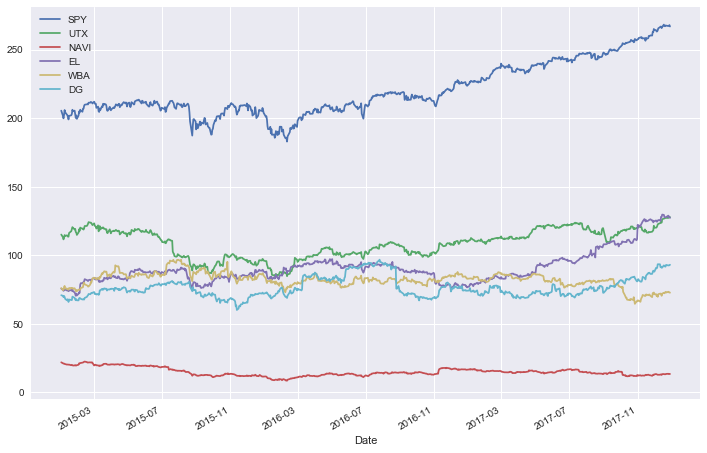

In [9]:
df.plot(figsize = (12, 8));

In [10]:
log_returns = np.log(df)
log_returns = log_returns.diff().dropna()
log_returns.head()

,SPY,UTX,NAVI,EL,WBA,DG
Date,,,,,,
2015-01-05,-0.018225,-0.016831,-0.033554,-0.012112,-0.019934,-0.006520
2015-01-06,-0.009464,-0.014245,-0.009524,-0.009282,0.002547,-0.012737
2015-01-07,0.012384,0.010792,0.000957,0.004585,0.025251,0.012026
2015-01-08,0.017589,0.016888,-0.015415,0.014293,0.012326,-0.010874
2015-01-09,-0.008046,-0.005510,-0.002917,-0.006653,-0.024541,-0.020200


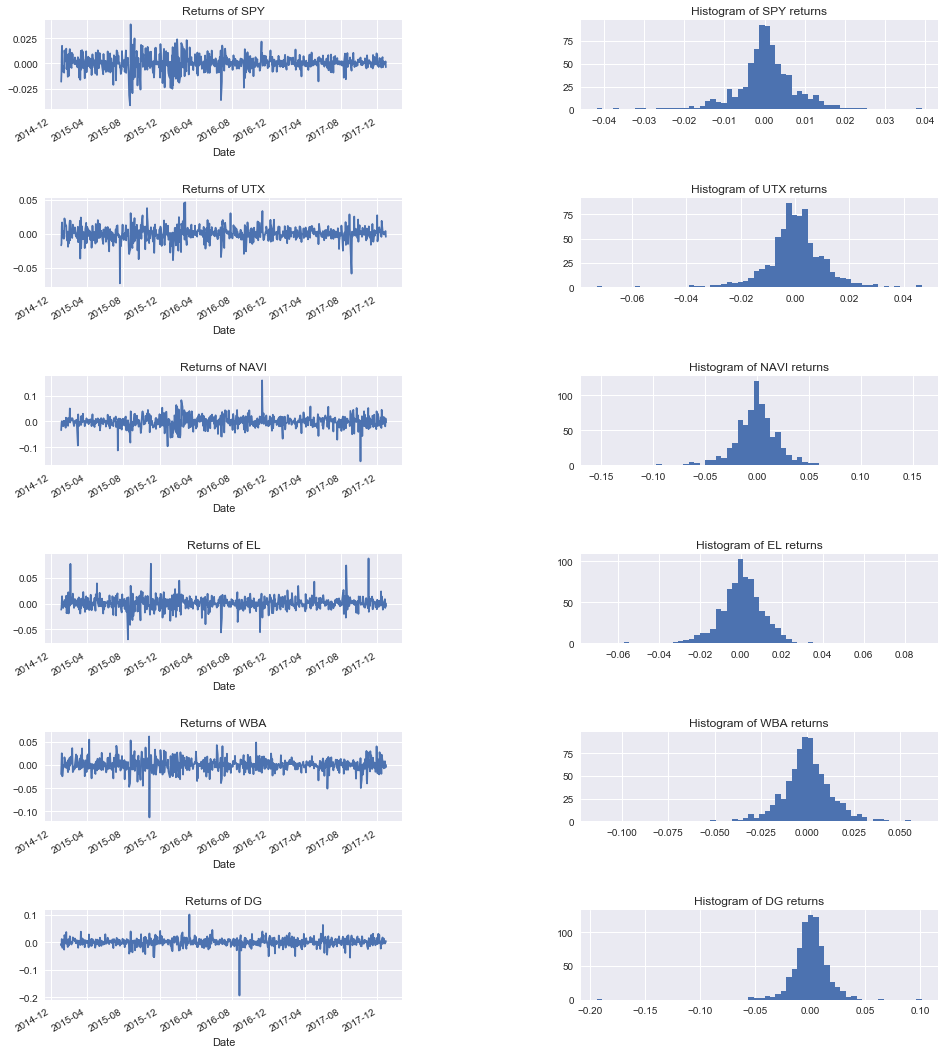

In [11]:
nb = len(listExtractTickers)
fig, axs = plt.subplots(nrows=nb, ncols=2, figsize=(16, 20))

for i in range(nb):
    ticker = listExtractTickers[i]
    plt.subplot(nb, 2, 2*i+1)
    log_returns[ticker].plot()
    plt.title('Returns of %s' %ticker)
    plt.subplot(nb, 2, 2*i+2)
    log_returns[ticker].hist(bins=60)
    plt.title('Histogram of %s returns' %ticker)
    
plt.subplots_adjust(hspace=1., wspace=0.5)
plt.show()

# 4. Testing on real data

...

(0.01148705507237046, 0.012912654671420398)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
D:\anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


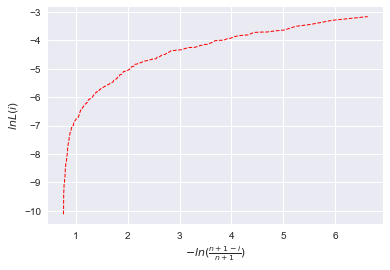

(1.3286501010311762, -0.36351972042890873, 0.003354991149115838, -0.0026414182868947965)


In [33]:
a = -1 * np.array(log_returns['SPY'])
pe = Pareto_Estimator(a, 0.9)
alpha, C = pe.fit_pareto()
print(pe.quantile(0.95))
pe.pareto_plot()

stable = Stable_Estimator(a)
print(stable.fit_stable())

# 5. Discussion

...

# 6. Conclusion

...